# Transfer learning with TensorFlow Hub

- This tutorial demonstrates how to use image classification models from [TensorFlow Hub](https://tfhub.dev/) with ```tf.keras``` and do simple transfer learning using flower image dataset.

### Import TensorFlow and necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.9.1


In [2]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2

In [3]:
image_shape = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=image_shape + (3,))
])

### Run the classifer model on a single image

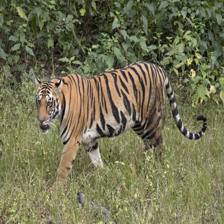

In [5]:
tiger_image_url = 'https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg'
tiger_image = tf.keras.utils.get_file('tiger', origin=tiger_image_url)
tiger_image = Image.open(tiger_image).resize(image_shape)
tiger_image

In [6]:
tiger_image = np.array(tiger_image) / 255.0
tiger_image.shape

(224, 224, 3)

In [7]:
prediction = classifier.predict(tf.expand_dims(tiger_image, 0)) # add a batch dimension
prediction.shape

1/1 [==============================] - 1s 640ms/step


(1, 1001)

In [8]:
predicted_class_label = np.argmax(prediction[0])
predicted_class_label

293

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

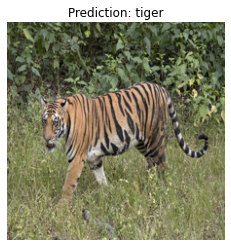

In [11]:
plt.figure()
plt.imshow(tiger_image)
predicted_class_name = imagenet_labels[predicted_class_label]
plt.title('Prediction: {}'.format(predicted_class_name))
plt.axis('off')
plt.show()

### Simple transfer learning

- Create a custom classifier using brand-new dataset that has classes that are not contained in the ImageNet dataset.

In [12]:
flower_dataset_path = tf.keras.utils.get_file('flower_photos', origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)

In [13]:
flower_dataset_path

'C:\\Users\\Ji Hun\\.keras\\datasets\\flower_photos'

In [14]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(flower_dataset_path),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(flower_dataset_path),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
# the flower dataset has five classes
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255) # the model expects float inputs in the [0, 1] range
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # where x-images, y-labels
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # where x-images, y-labels

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Run the classifier on a batch of images

In [18]:
initial_trial = classifier.predict(train_ds)

92/92 [==============================] - 71s 760ms/step


In [20]:
initial_trial.shape

(2936, 1001)

In [21]:
predicted_class_names = imagenet_labels[tf.math.argmax(initial_trial, axis=-1)]

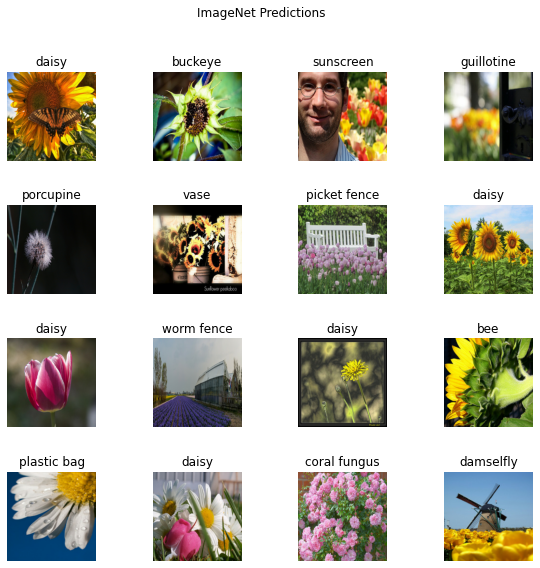

In [33]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for images, _ in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(predicted_class_names[i])
        plt.axis('off')

plt.suptitle('ImageNet Predictions')
plt.show()

# ImageNet predictions are far from perfect, but reasonable considering that these are not the classes of the trained model except 'daisy'. 

### Download the headless model

- TensorFlow Hub also provides models without the top classification layer. 

In [34]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [35]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False # freeze the variables, so that the training only modifies the new classifier layer
)

### Attach a classification layer

In [36]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [39]:
num_epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs
)

Epoch 1/10
92/92 [==============================] - 89s 900ms/step - loss: 0.7413 - accuracy: 0.7337 - val_loss: 0.4313 - val_accuracy: 0.8597
Epoch 2/10
92/92 [==============================] - 80s 867ms/step - loss: 0.3666 - accuracy: 0.8764 - val_loss: 0.3489 - val_accuracy: 0.8896
Epoch 3/10
92/92 [==============================] - 80s 869ms/step - loss: 0.2872 - accuracy: 0.9074 - val_loss: 0.3179 - val_accuracy: 0.8992
Epoch 4/10
92/92 [==============================] - 86s 940ms/step - loss: 0.2389 - accuracy: 0.9254 - val_loss: 0.3013 - val_accuracy: 0.9019
Epoch 5/10
92/92 [==============================] - 87s 950ms/step - loss: 0.2047 - accuracy: 0.9394 - val_loss: 0.2909 - val_accuracy: 0.9033
Epoch 6/10
92/92 [==============================] - 93s 1s/step - loss: 0.1785 - accuracy: 0.9499 - val_loss: 0.2838 - val_accuracy: 0.9005
Epoch 7/10
92/92 [==============================] - 95s 1s/step - loss: 0.1576 - accuracy: 0.9601 - val_loss: 0.2788 - val_accuracy: 0.9019
Epoch

### Check the predictions

In [41]:
predicted_batch = model.predict(train_ds.take(1))
predicted_batch.shape

1/1 [==============================] - 1s 704ms/step


(32, 5)

In [47]:
predicted_idx = tf.math.argmax(predicted_batch, axis=-1)
predicted_batch_labels = [class_names[i] for i in predicted_idx]
predicted_batch_labels

['sunflowers',
 'sunflowers',
 'tulips',
 'tulips',
 'dandelion',
 'sunflowers',
 'tulips',
 'sunflowers',
 'tulips',
 'tulips',
 'dandelion',
 'sunflowers',
 'daisy',
 'daisy',
 'roses',
 'tulips',
 'dandelion',
 'sunflowers',
 'dandelion',
 'dandelion',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'dandelion',
 'sunflowers',
 'tulips',
 'dandelion',
 'tulips',
 'tulips',
 'tulips',
 'sunflowers']

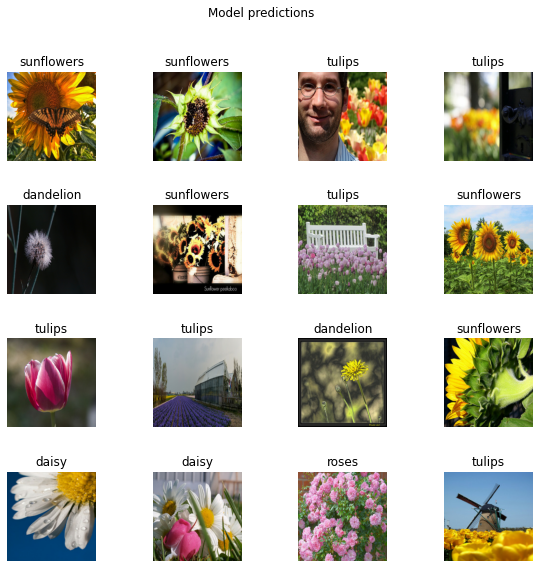

In [52]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for images, labels in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        if (class_names[labels[i]] == predicted_batch_labels[i]): # check if predictions are different from the target values
            plt.title(predicted_batch_labels[i])
        plt.axis('off')
        
plt.suptitle('Model predictions')
plt.show()

### Save the model

In [53]:
flower_model_path = 'models/flower_model'
model.save(flower_model_path)

INFO:tensorflow:Assets written to: models/flower_model\assets


INFO:tensorflow:Assets written to: models/flower_model\assets
